In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import seaborn as sn
import statsmodels.api as sm
from pylab import rcParams

2022-09-20 16:32:25.284361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 16:32:26.045058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 16:32:26.045106: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-20 16:32:26.134833: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 16:32:28.207044: W tensorflow/stream_executor/platform/de

In [2]:
#Read the csv file
df=pd.read_csv('merged_data.csv',parse_dates=['mkt_datetime'])

In [3]:
df=df[:23376]

In [4]:
df.head()

,mkt_datetime,int_nuc_sch,int_gas_sch,int_hyd_sch,int_win_sch,imp_mic_sch,imp_new_sch,imp_que_sch,ont_avg_dem,exp_mic_sch,exp_new_sch,exp_que_sch,ont_ene
0,2020-01-01 00:00:00,11554,216,2857,2113,0,0,9,13305,-800,-1285,-1273,0.0
1,2020-01-01 01:00:00,11554,216,2834,1595,0,0,9,12870,-800,-1285,-1273,0.0
2,2020-01-01 02:00:00,11554,216,2834,1506,0,0,9,12512,-800,-1390,-1273,0.0
3,2020-01-01 03:00:00,11554,216,2835,1592,0,0,9,12370,-800,-1443,-1273,0.0
4,2020-01-01 04:00:00,11554,216,2911,1479,0,0,9,12469,-800,-1440,-1273,0.0


In [5]:
#Variables for training
cols = list(df)[0:13]
uni_df=df[cols]
uni_df.set_index('mkt_datetime', inplace=True)

In [6]:
uni_df.head()

,int_nuc_sch,int_gas_sch,int_hyd_sch,int_win_sch,imp_mic_sch,imp_new_sch,imp_que_sch,ont_avg_dem,exp_mic_sch,exp_new_sch,exp_que_sch,ont_ene
mkt_datetime,,,,,,,,,,,,
2020-01-01 00:00:00,11554,216,2857,2113,0,0,9,13305,-800,-1285,-1273,0.0
2020-01-01 01:00:00,11554,216,2834,1595,0,0,9,12870,-800,-1285,-1273,0.0
2020-01-01 02:00:00,11554,216,2834,1506,0,0,9,12512,-800,-1390,-1273,0.0
2020-01-01 03:00:00,11554,216,2835,1592,0,0,9,12370,-800,-1443,-1273,0.0
2020-01-01 04:00:00,11554,216,2911,1479,0,0,9,12469,-800,-1440,-1273,0.0


In [7]:
y = uni_df['ont_ene'].resample('MS').mean()

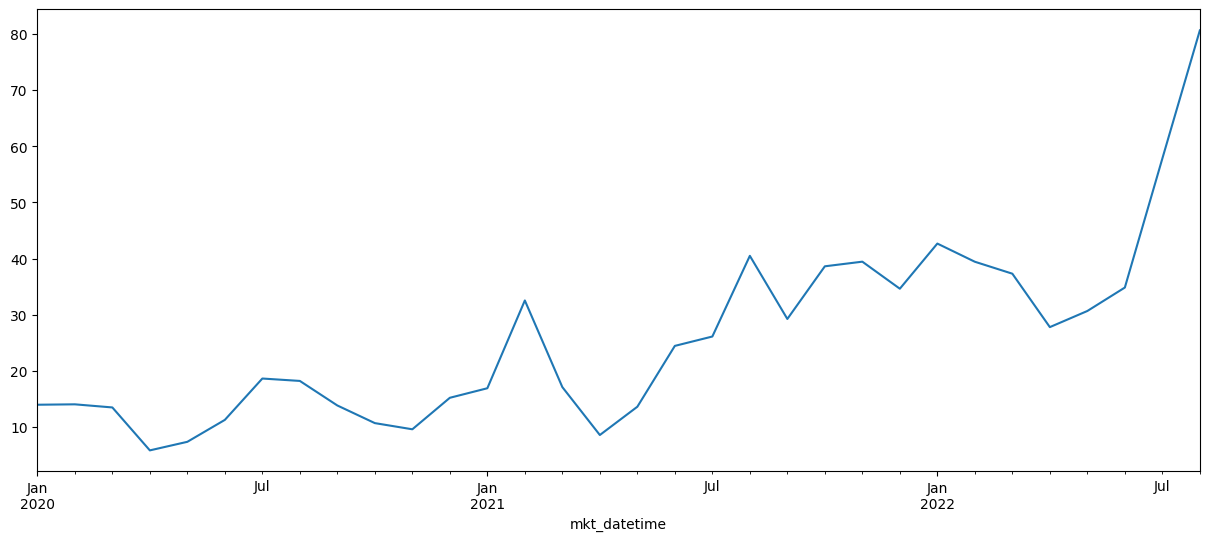

In [8]:
y.plot(figsize=(15, 6))
plt.show()

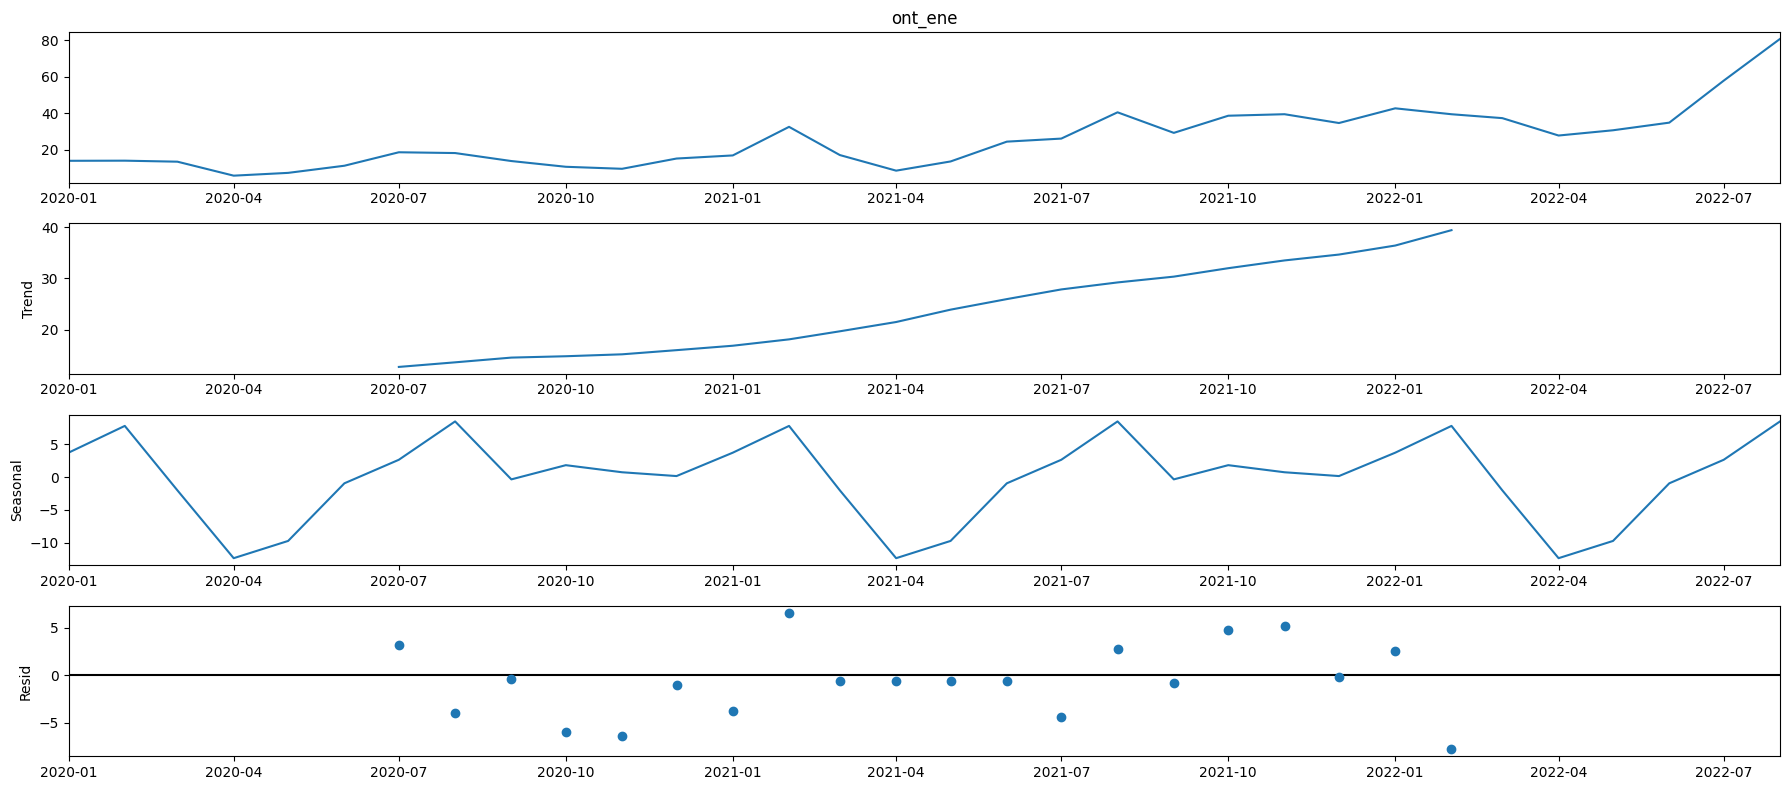

In [9]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [10]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
uni_df_scaled = sc.fit_transform(uni_df)

In [11]:
print(uni_df_scaled[0])

[0.90782302 0.0141516  0.20030311 0.46185792 0.         0.
 0.00349108 0.227      0.53188999 0.26571429 0.42241379 0.0027082 ]


In [12]:
# uni_df.head(1)

In [13]:
# uni_df.describe()

In [14]:
# split into train and test sets
train_size = int(len(uni_df) * 0.70)
test_size = len(uni_df) - train_size
train, test = uni_df_scaled[0:train_size,:], uni_df_scaled[train_size:len(uni_df),:]

In [15]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), :]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 11])
    return np.array(data_x), np.array(data_y)

In [16]:
# reshape into X=t and Y=t+1
look_back =96
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

In [17]:
# groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# i = 1
# # plot each column
# values=uni_df.values
# plt.figure(figsize=(14, 10))
# for group in groups:
# 	plt.subplot(len(groups), 1, i)
# 	plt.plot(values[:1000, group])
# 	plt.title(uni_df.columns[group], y=0.5, loc='right')
# 	i += 1
# plt.show()

In [20]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 96, 60)            17520     
                                                                 
 dropout_3 (Dropout)         (None, 96, 60)            0         
                                                                 
 lstm_4 (LSTM)               (None, 96, 60)            29040     
                                                                 
 dropout_4 (Dropout)         (None, 96, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_5 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [41]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
1085/1085 [==============================] - 164s 151ms/step - loss: 2.2608e-04 - val_loss: 3.2403e-04 - lr: 0.0010
Epoch 2/20
1085/1085 [==============================] - 183s 169ms/step - loss: 2.2136e-04 - val_loss: 3.1373e-04 - lr: 0.0010
Epoch 3/20
1085/1085 [==============================] - 268s 247ms/step - loss: 2.1806e-04 - val_loss: 3.0591e-04 - lr: 0.0010
Epoch 4/20
1085/1085 [==============================] - 186s 171ms/step - loss: 2.1515e-04 - val_loss: 3.0317e-04 - lr: 0.0010
Epoch 5/20
1085/1085 [==============================] - 170s 157ms/step - loss: 2.1291e-04 - val_loss: 3.0177e-04 - lr: 0.0010
Epoch 6/20
1085/1085 [==============================] - 202s 186ms/step - loss: 2.1042e-04 - val_loss: 2.9429e-04 - lr: 0.0010
Epoch 7/20
1085/1085 [==============================] - 191s 176ms/step - loss: 2.0851e-04 - val_loss: 2.8757e-04 - lr: 1.0000e-04
Epoch 8/20
1085/1085 [==============================] - 178s 164ms/step - loss: 2.0694e-04 - val_loss: 2.82

In [42]:
regressor.save('lstm_multi_model2')

INFO:tensorflow:Assets written to: lstm_multi_model2/assets


INFO:tensorflow:Assets written to: lstm_multi_model2/assets


In [51]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

217/217 [==============================] - 14s 63ms/step


In [52]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [53]:
colNames=list(uni_df)
colName='ont_ene'

In [54]:
# invert predictions
train_predict = invTransform(sc,train_predict,colName,colNames)
Y_train_inv = invTransform(sc,Y_train,colName,colNames)
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)

Train Mean Absolute Error: 8.447725875435347
Train Root Mean Squared Error: 24.00518936905069
Test Mean Absolute Error: 17.760427585922482
Test Root Mean Squared Error: 30.61160274271712


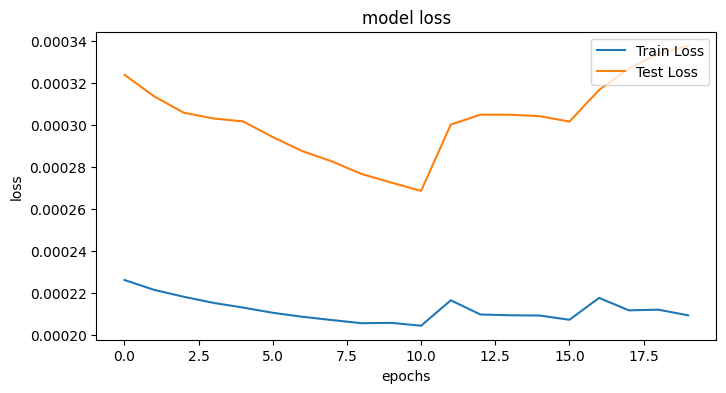

In [55]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

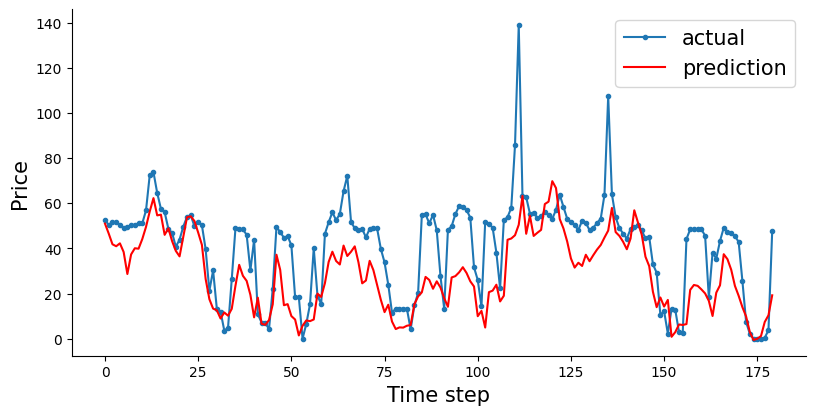

In [61]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_inv[1800:1980], marker='.', label="actual")
plt.plot(aa, test_predict[1800:1980], 'r', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();